# Article Classification

The goal of this notebook is to read, appropriately clean and preprocess a number of articles and then classify them on one of these 4 categories:
* Business
* Entertainment
* Health
* Technology


In [ ]:
import string
import re
import pickle
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
!pip3 install stop_words
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV

# !pip3 install bayesian-optimization
from bayes_opt import BayesianOptimization

import xgboost as xgb

from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm

nltk.download('stopwords')
nltk.download('wordnet')

## Preprocessing Pipeline

The preprocessing step includes reading the texts, cleaning the text (stopwords, lemmatization, remove high-frequency words, forming wordclouds). In the end, the preprocessed texts should be saved on disk to avoid repeaeting these steps.

### Reading


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_without_labels.csv')

display(df_train)

,Id,Title,Content,Label
0,227464,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment
1,244074,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment
2,60707,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology
3,27883,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology
4,169596,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business
...,...,...,...,...
111790,31462,Microsoft requires Office 2013 licensing for s...,in contrast to the muckle of special licenses...,Technology
111791,100821,Smallpox vials missing since 1950s found in la...,government workers at a research center near ...,Health
111792,86181,Scientists May Have Just Discovered the Key to...,harvard scientists may have just unlocked the...,Health
111793,256423,Justin Bieber to plead guilty to DUI,"justin bieber to plead guilty to duifri, 13 ju...",Entertainment


We observe if the population of our classes is balanced.

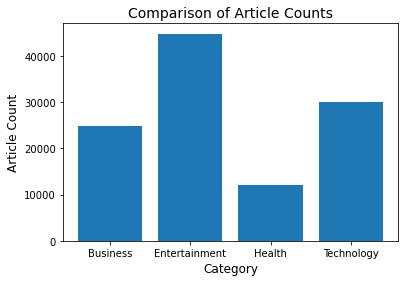

In [ ]:
class_counts = df_train.groupby('Label').count().Content

plt.bar(np.arange(len(class_counts)), class_counts.values, align='center')
plt.xticks(np.arange(len(class_counts)), class_counts.index)
plt.ylabel('Article Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.title('Comparison of Article Counts', fontsize=14)
plt.show()

Immediately we observe that our dataset is imbalanced with the Health category having the smallest amount of datapoints. As we progress we should take this under account.

### Wordclouds

Wordclouds can give a preliminary peek on our dataset since they are able to summarize the content of the texts per class.
We want to focus on words that are not common in all texts so we remove them using stopwords and manually remove words that appear on all the stopwords.

In [ ]:
business_texts = " ".join(text for text in df_train[df_train["Label"]=="Business"].Content)
entertainment_texts = " ".join(text for text in df_train[df_train["Label"]=="Entertainment"].Content)
health_texts = " ".join(text for text in df_train[df_train["Label"]=="Health"].Content)
technology_texts = " ".join(text for text in df_train[df_train["Label"]=="Technology"].Content)

stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))

stop_words.extend(nltk_words)
stop_words.extend(('said', 'u', 'one', 'also', 'may'))  # We manually add some extra stopwords that are common on all 4 wordclouds

wordcloud_business = WordCloud(stopwords=stop_words, width=1600, height=800, background_color="white", mode="RGB", max_words=200).generate(business_texts)
wordcloud_entertainment = WordCloud(stopwords=stop_words, background_color="white", mode="RGB", max_words=200).generate(entertainment_texts)
wordcloud_health = WordCloud(stopwords=stop_words, background_color="white", mode="RGB", max_words=200).generate(health_texts)
wordcloud_technology = WordCloud(stopwords=stop_words, background_color="white", mode="RGB", max_words=200).generate(technology_texts)

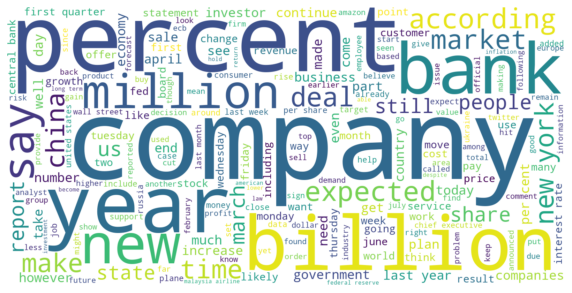

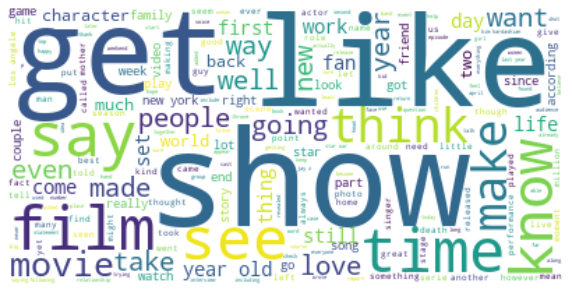

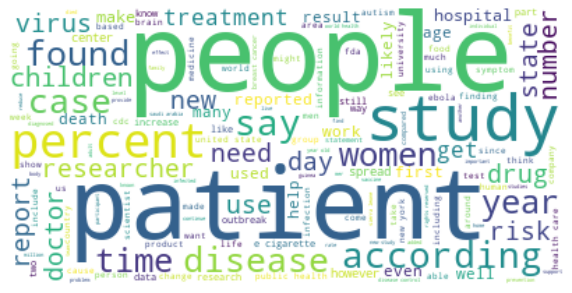

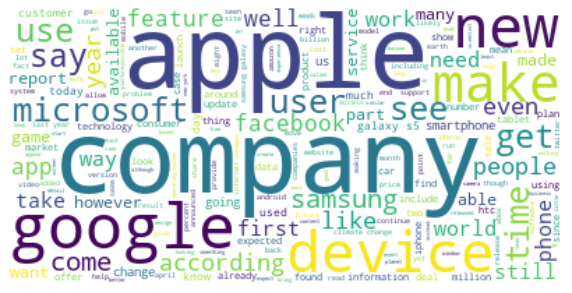

In [ ]:
# Create and save a plot of the wordcloud
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_business, interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../storage/wordclouds/business_wc.png", format="png")

plt.show()

plt.figure(figsize=[10,10])
plt.imshow(wordcloud_entertainment, interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../storage/wordclouds/entertainment_wc.png", format="png")

plt.show()

plt.figure(figsize=[10,10])
plt.imshow(wordcloud_health, interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../storage/wordclouds/health_wc.png", format="png")

plt.show()

plt.figure(figsize=[10,10])
plt.imshow(wordcloud_technology, interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../storage/wordclouds/technology_wc.png", format="png")

plt.show()

### Cleaning

The use case and the source of the text define which cleaning steps we should apply. For example, in our case removal of stopwords seems important while spelling correction probably won't have great effects since all these are articles and should mostly have correct spelling.

The cleaning steps we consider are:
* Remove like punctuation
* Lowering all the letters
* Removing stopwrods
* Lemmatization
* Stemming
* Frequent / rare word removal

Of course, finding the correct combination of the above cleaning steps requires experimentation along with intuition. We should note that the order one performs the above steps matter a lot. Usually, the noise removal step should be done first so as to have distinct words. For example applying stemming to `<a>troubling</a>` will result to `<a>troubling</a>` while we would expect something like `troubl`.


In [ ]:
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stop_words.extend(nltk_words)

def benchmark_clean_text(text):
    # Lower words
    cleaned = text.lower()
    
    # Remove stopwords. Needed to be done before the apostrophes are removed
    cleaned = ' '.join([w for w in cleaned.split() if not w in stop_words])
    
    # Remove punctuation
    cleaned = cleaned.translate(str.maketrans('', '', string.punctuation +'–—‘’“”…')) 
    
    # Replace all the remaining numbers that did not match any of the above categories  
    number_pattern = re.compile(r'(\d{1,3},)?(\d{3},)*\d+(\.\d+)?')
    cleaned = number_pattern.sub(r' ', cleaned)

    # lemmatization
    cleaned = " ".join([lemmatizer.lemmatize(word) for word in cleaned.split()])
    
    # Stemming
#     cleaned = " ".join([stemmer.stem(word) for word in cleaned.split()])

    return cleaned

In [ ]:
# Benchmark Train Set Preprocessed saving
cleaned_train_df_bench = df_train.copy(deep=True)

cleaned_train_content = cleaned_train_df_bench.Content.apply(lambda text: benchmark_clean_text(text))
cleaned_train_df_bench = cleaned_train_df_bench.assign(CleanedContent=cleaned_train_content)

cleaned_train_df_bench.drop(columns=['Content', 'Title'], inplace=True)
cleaned_train_df_bench.to_csv('../storage/datasets/preprocessed/benchmark_texts_train.csv', sep=',')

# Benchmark Test Set Preprocessed saving
cleaned_test_df_bench = df_test.copy(deep=True)

cleaned_test_content = cleaned_test_df_bench.Content.apply(lambda text: benchmark_clean_text(text))
cleaned_test_df_bench = cleaned_test_df_bench.assign(CleanedContent=cleaned_test_content)

cleaned_test_df_bench.drop(columns=['Content', 'Title'], inplace=True)
cleaned_test_df_bench.to_csv('../storage/datasets/preprocessed/benchmark_texts_test.csv', sep=',')

In [ ]:
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stop_words.extend(nltk_words)

def clean_text(text, prefix=None):
    # Lower words
    cleaned = text.lower()
    
    # Remove / replace urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    cleaned = url_pattern.sub(r'HTTPSYMBOL', cleaned)  # Currently replacing all URLs with HTTP
    
    # Remove / replace full dates
    date_pattern = re.compile(r'\d{1,2}(\/|-)\d{1,2}(\/|-)\d{2,4}')
    cleaned = date_pattern.sub(r' DATESYMBOL ', cleaned)
    
    # Replace money amounts with MONEY
    money_pattern_curr_forward = re.compile(r'(US|us)?(\$|€)(\d+\,)*\d+\.?\d*')
    cleaned = money_pattern_curr_forward.sub(r' MONEYSYMBOL ', cleaned)

    money_pattern_curr_back = re.compile(r'(\d+\,)*\d+\.?\d+(\$|€)')
    cleaned = money_pattern_curr_back.sub(r' MONEYSYMBOL ', cleaned)
    
    # Replace smart quotes with usual ones ’ -> '
    cleaned = cleaned.replace( '’', "'")
    
    # Replace open/close smart quotes with symbols “ -> OPENQUOTESYMBOL, ” -> CLOSEQUOTESYMBOL
    cleaned = cleaned.replace( '“', " OPENQUOTESYMBOL ")
    cleaned = cleaned.replace( '”', " CLOSEQUOTESYMBOL ")
    
    # Replace Parenthesis
    cleaned = cleaned.replace( '(', " PARENTHESISSYMBOL ")
    cleaned = cleaned.replace( ')', " PARENTHESISSYMBOL ")
    
    # Remove stopwords. Needed to be done before the apostrophes are removed
    cleaned = ' '.join([w for w in cleaned.split() if not w in stop_words])
    
    # Remove / replace probable year dates
    tokens = cleaned.split()
    cleaned_tokens = []
    for w in tokens:
        if w.isdigit():
            try:
                if 1900 < int(w) < 2025:
                    cleaned_tokens.append(' DATESYMBOL ')
            except ValueError:
                cleaned_tokens.append(w)
        else:
            cleaned_tokens.append(w)
    cleaned = ' '.join(cleaned_tokens)
    
    # Replace all the remaining numbers that did not match any of the above categories  
    number_pattern = re.compile(r'(\d{1,3},)?(\d{3},)*\d+(\.\d+)?')
    cleaned = number_pattern.sub(r' NUMBERSYMBOL ', cleaned)
    
    # Replace ellipsis (..., …) with ELLIPSISSYMBOL
    cleaned = cleaned.replace( '...', " ELLIPSISSYMBOL ")
    cleaned = cleaned.replace( '…', " ELLIPSISSYMBOL ")
    
    # Add a space after , and .
    cleaned = cleaned.replace( ',', ", ")
    cleaned = cleaned.replace( '.', ". ")
    
    # Remove punctuation
    cleaned = cleaned.translate(str.maketrans('', '', string.punctuation +'–—‘')) 
    
    # lemmatization
    cleaned = " ".join([lemmatizer.lemmatize(word) for word in cleaned.split()])
    
    # Stemming
#     cleaned = " ".join([stemmer.stem(word) for word in cleaned.split()])

    # Prepend o prefix on every word (eg to distinguish title words from content words)
    if prefix is not None:
        cleaned = " ".join([prefix + word for word in cleaned.split()])
    
    return cleaned

In [4]:
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stop_words.extend(nltk_words)

# output = [w for w in word_list if not w in stop_words]
def clean_text_ver2(text, prefix=None):
    # Lower words
    cleaned = text.lower()
    
    # Remove / replace urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    cleaned = url_pattern.sub(r'HTTPSYMBOL', cleaned)  # Currently replacing all URLs with HTTP
    
    # Remove / replace full dates
    date_pattern = re.compile(r'\d{1,2}(\/|-)\d{1,2}(\/|-)\d{2,4}')
    cleaned = date_pattern.sub(r' DATESYMBOL ', cleaned)
    
    # Replace money amounts with MONEY
    money_pattern_curr_forward = re.compile(r'(US|us)?(\$|€)(\d+\,)*\d+\.?\d*')
    cleaned = money_pattern_curr_forward.sub(r' MONEYSYMBOL ', cleaned)

    money_pattern_curr_back = re.compile(r'(\d+\,)*\d+\.?\d+(\$|€)')
    cleaned = money_pattern_curr_back.sub(r' MONEYSYMBOL ', cleaned)
    
    # Replace encoded apostrophe with usual ones ’ -> '
    cleaned = cleaned.replace( '’', "'")
    
    # Replace open/close smart quotes with symbols “ -> OPENQUOTESYMBOL, ” -> CLOSEQUOTESYMBOL
    cleaned = cleaned.replace( '"', " QUOTESYMBOL ")
    cleaned = cleaned.replace( '“', " QUOTESYMBOL ")
    cleaned = cleaned.replace( '”', " QUOTESYMBOL ")
    
    # Remove stopwords. Needed to be done before the apostrophes are removed
    cleaned = ' '.join([w for w in cleaned.split() if not w in stop_words])
    
    # Remove / replace probable year dates
    tokens = cleaned.split()
    cleaned_tokens = []
    for w in tokens:
        if w.isdigit():
            try:
                if 1900 < int(w) < 2025:
                    cleaned_tokens.append(' DATESYMBOL ')
            except ValueError:
                cleaned_tokens.append(w)
        else:
            cleaned_tokens.append(w)
    cleaned = ' '.join(cleaned_tokens)
    
    # Replace all the remaining numbers that did not match any of the above categories  
    number_pattern = re.compile(r'(\d{1,3},)?(\d{3},)*\d+(\.\d+)?')
    cleaned = number_pattern.sub(r' NUMBERSYMBOL ', cleaned)
    
    # Replace ellipsis (..., …) with ELLIPSISSYMBOL
    cleaned = cleaned.replace( '...', " ELLIPSISSYMBOL ")
    cleaned = cleaned.replace( '…', " ELLIPSISSYMBOL ")
    
    # Add a space after , and .
    cleaned = cleaned.replace( ',', ", ")
    cleaned = cleaned.replace( '.', ". ")
    
    # Remove punctuation
    cleaned = cleaned.translate(str.maketrans('', '', string.punctuation +'–—‘')) 
    
    # lemmatization
    cleaned = " ".join([lemmatizer.lemmatize(word) for word in cleaned.split()])
    
    # Stemming
#     cleaned = " ".join([stemmer.stem(word) for word in cleaned.split()])

    # Prepend o prefix on every word (eg to distinguish title words from content words)
    if prefix is not None:
        cleaned = " ".join([prefix + word for word in cleaned.split()])
    
    return cleaned

Apply the above preprocessing on both the content and the title of the whole dataset. Then save it to disk to avoid repeating these steps.

In [5]:
# Train Set Preprocessed saving
cleaned_train_df = df_train.copy(deep=True)

cleaned_train_content = cleaned_train_df.Content.apply(lambda text: clean_text(text, prefix="TEXT_"))
cleaned_train_df = cleaned_train_df.assign(CleanedContent=cleaned_train_content)

cleaned_train_title = cleaned_train_df.Title.apply(lambda title: clean_text(title, prefix="TITLE_"))
cleaned_train_df = cleaned_train_df.assign(CleanedTitle=cleaned_train_title)

cleaned_train_title_added = cleaned_train_df.Title.apply(lambda title: (clean_text(title, prefix="TEXT_") + " ") * 3)
cleaned_train_df = cleaned_train_df.assign(CleanedTitleAdded=cleaned_train_title_added)

cleaned_train_df.drop(columns=['Content', 'Title'], inplace=True)
cleaned_train_df.to_csv('added_title_train.csv', sep=',')

In [6]:
# Test Set Preprocessed saving
cleaned_test_df = df_test.copy(deep=True)

cleaned_test_content = cleaned_test_df.Content.apply(lambda text: clean_text(text, prefix="TEXT_"))
cleaned_test_df = cleaned_test_df.assign(CleanedContent=cleaned_test_content)

cleaned_test_title = cleaned_test_df.Title.apply(lambda title: clean_text(title, prefix="TITLE_"))
cleaned_test_df = cleaned_test_df.assign(CleanedTitle=cleaned_test_title)

cleaned_test_title_added = cleaned_test_df.Title.apply(lambda title: (clean_text(title, prefix="TEXT_") + " ") * 3)
cleaned_test_df = cleaned_test_df.assign(CleanedTitleAdded=cleaned_test_title_added)

cleaned_test_df.drop(columns=['Content', 'Title'], inplace=True)
cleaned_test_df.to_csv('added_title_test.csv', sep=',')

## Feauture Extraction




In [7]:
# Read the preprocessed train and test
df_proc_train = pd.read_csv('added_title_train.csv')
df_proc_test = pd.read_csv('added_title_test.csv')

In this part we have to transform our preprocessed texts from a series of words to a vector which is the expected input for our machine learning algorithms.

One main category is the Bag of Words approach where when we transform our  texts we care about the frequencies of each word and not their local context.  
**Bag of Words techniques**:
* **Count Vectorizer**, is the most simple approach which has the disadvantage of giving bigger weight on longer texts
* **Term Frequency (TF)**, deals with the above disadvantage since our counts are normalized by the length of the text
* **Term Frequency - Inverse Document Frequency (TF-IDF)**, also reduces the weight of common words that are not and increase the weight of rare words since the rare words are more prominent to differentiate our articles. This also means that we do not have to finetune carefully the max_df and min_df. 


In [8]:
# Using the title
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, ngram_range=(1,2))
label_encoder = LabelEncoder()

combined_content_title_train = df_proc_train.CleanedContent.astype(str) + df_proc_train.CleanedTitle.astype(str) + df_proc_train.CleanedTitleAdded.astype(str)
combined_content_title_test = df_proc_test.CleanedContent.astype(str) + df_proc_test.CleanedTitle.astype(str) + df_proc_test.CleanedTitleAdded.astype(str) 

X_tfidf = tfidf_vectorizer.fit_transform(combined_content_title_train)

print(X_tfidf.shape)

Y = df_proc_train.Label
Y_enc = label_encoder.fit_transform(Y)

X_test_tfidf = tfidf_vectorizer.transform(combined_content_title_test)

(111795, 9830387)


In [9]:
# Not using the title
tfidf_vectorizer = TfidfVectorizer()
label_encoder = LabelEncoder()

X_tfidf = tfidf_vectorizer.fit_transform(df_proc_train.CleanedContent)

Y = df_proc_train.Label
Y_enc = label_encoder.fit_transform(Y)

X_test_tfidf = tfidf_vectorizer.transform(df_proc_test.CleanedContent)

### Title and Text Sizes Impact

We examine if there is any significant correlation between the title size and the article category.

In [ ]:
title_lens =  df_proc_train[:100000].CleanedTitle.apply(lambda text: len(text.split()))
title_labels = df_proc_train.Label

title_mean_length = pd.concat([title_lens, title_labels], axis=1).groupby('Label').mean()

content_lens =  df_proc_train[:100000].CleanedContent.apply(lambda text: len(text.split()))
content_labels = df_proc_train.Label

content_mean_length = pd.concat([content_lens, content_labels], axis=1).groupby('Label').mean()

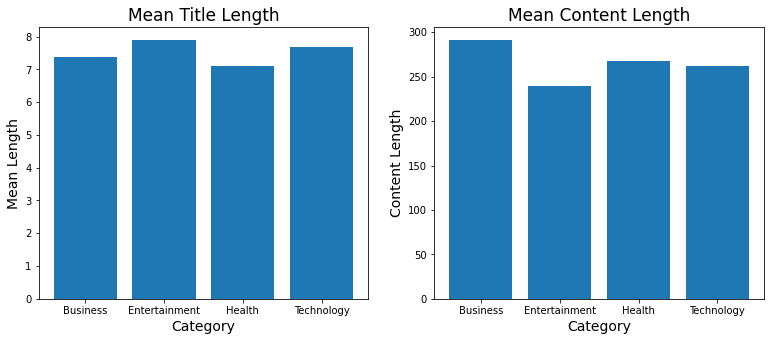

In [ ]:
fig = plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(title_mean_length)), title_mean_length.values[:, 0], align='center')
plt.xticks(np.arange(len(title_mean_length)), title_mean_length.index)
plt.ylabel('Mean Length', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.title('Mean Title Length', fontsize=17)

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(content_mean_length)), content_mean_length.values[:, 0], align='center')
plt.xticks(np.arange(len(content_mean_length)), content_mean_length.index)
plt.ylabel('Content Length', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.title('Mean Content Length', fontsize=17)
plt.show()

We observe that the cotnent length could offer us some separability since we observe that on average the entertainment has smaller titles. We colud add this feature next to the features genarated with our BoW techniques in order to check if there is any accuracy increase.

### Dimensionallity Reduction

The above frequency matrices are sparse (many 0s) a document usually includes a small subset of our while vocabularly. This has a negative impact in memory usage and performance of the following classification algorithms. There are many dimensionallity techniques which aim to reduce the dimensions while keeping as much information as possible.

In our case we will use `SVD` which is a linear dimensionallity reduction technique. In order to evaluate how much information we lose, we will print the variance captured from the first k PCs we keep.

In [ ]:
def apply_SVD(X_train, final_dim, X_test=None):
    svd = TruncatedSVD(n_components=final_dim, n_iter=5)
    
    svd.fit(X_train)
    print(f"Variance captured: {np.round(sum(svd.explained_variance_ratio_), decimals=2)}")
    
    if X_test is not None:
        return svd.transform(X_train), svd.transform(X_test) 
    else:
        return svd.transform(X_train)
    
X_truncated_train = apply_SVD(X_tfidf, 1000)

Variance captured: 0.71


## Model Evaluation and Finetuning

In this section we create suitable pipelines for training and evaluating models like RandomForest and SVM.

In order to get the most out of the classifiers we have to tune their respective hyperparameters. We achieve that using `GridSearch`. The main difficulty however is that grid search evaluates every possible combination of the possible parameters we have given as input making it exponentially time consuming especially on our >100k training samples.  
We follow the pipeline below in order to get the most of both hyperparameter tuning and evaluation:
* We perform grid search on a great set of hyperparameters but on a smaller sample of the training set (eg 0.2)
* We take the top-k parameter combinations and we evaluate them on the whole dataset
* We pick the best estimator

Following that, we perform bayesian optimization on our top methods and then combine their results into an ensemble.

In [10]:
def metrics_calculating(y_true, y_pred):
    return Counter({
        'accuracy': accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    })


def pretty_print_grid_search(gs_obj):
    print(f"Best parameters found: {gs_obj.best_params_}, with a score of: {np.round(gs_obj.best_score_, decimals=3)}")
    
    df_gs = pd.DataFrame.from_dict(gs_obj.cv_results_)
    display(df_gs)
    

def run_cross_val(model, splits_numb, X, y, lab_encoder=None):
    train_metrics = Counter()
    validation_metrics = Counter()
    conf_mats = []
    pred_vals = None
    
    kf = KFold(n_splits=splits_numb, shuffle=False)
    for train_index, val_index in tqdm(list(kf.split(X)), desc="Splits"):
        ### Fit on the input model ###
        model.fit(X[train_index], y[train_index])
        
        ### Predict on the Train set (mainly for debugging) ###
        y_pred_train = model.predict(X[train_index])
        
        ### Predict on the Validation set ###
        y_pred_val = model.predict(X[val_index])

        proba_preds = model.decision_function(X[val_index])
        try:
            pred_vals = np.concatenate((pred_vals,proba_preds))
        except:
            pred_vals = proba_preds
        
        ### Metrics Bookkeeping ###
        train_metrics += metrics_calculating(y[train_index], y_pred_train)
        validation_metrics += metrics_calculating(y[val_index], y_pred_val)
        
        print(train_metrics)
        print(validation_metrics)
        
        ### Confusion Plots Generation ###
        if lab_encoder is not None:
            y_labels_true = lab_encoder.inverse_transform(y[val_index])
            y_labels_pred = lab_encoder.inverse_transform(y_pred_val)
            
            conf_mats.append(confusion_matrix(y_labels_true, y_labels_pred, labels=list(lab_encoder.classes_)))
            

    if lab_encoder is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=np.sum(np.array(conf_mats), axis=0), 
                                      display_labels=list(lab_encoder.classes_))
        fig, ax=plt.subplots(1,1,figsize=(7,7))
        disp.plot(ax=ax)
        
    train_avg_metrics = {k: v / splits_numb for k, v in train_metrics.items()}
    validation_avg_metrics = {k: v / splits_numb for k, v in validation_metrics.items()}

    try:
        LOG['predictions'].append(pred_vals.copy())
    except:
        pass

    #print(accuracy_score(pred_vals,y))

    return train_avg_metrics, validation_avg_metrics


def run_grid_search(X, y, model, params, folds_numb, scoring="accuracy", verbose_res=True):
    gs = GridSearchCV(model, params, cv=folds_numb, scoring=scoring,
                  n_jobs=10, verbose=3)
    
    gs.fit(X, y)
    
    if verbose_res:
        pretty_print_grid_search(gs)
            
    return gs

def run_bayesian_optimization(params, obj_function,log=None,iters=8,inits=2):   #log needs to be a dictionary

    if log!=None:
        if 'predictions' not in log:
            log['predictions'] = []

    optimizer = BayesianOptimization(obj_function,params,verbose=2)#,random_state=42)

    optimizer.maximize(n_iter = iters,init_points=inits) #higher values are recommended, but time.

    if log!=None:
        if 'hyperparameters' not in log:
            log['hyperparameters'] = []
        if 'scores' not in log:
            log['scores'] = []
        for r in optimizer.res:
            log['hyperparameters'].append(r['params'])
            log['scores'].append(r['target'])

    return optimizer.max

**SVM**

A support vector machine (SVM) is a supervised machine learning model aiming to find a separating plane with the biggest margin 
between two classes. Of course, in our use case we require multiclassification so the OneVsRest or the OneVsOne strategies are employed.

**LinearSVC vs. SVC with linear kernel**

One by briefly looking on the documentation would expect the SVC with linear kernel and the LinearSVC to be the same. However, we noticed that while the fit time for SVC with linear kernel was around 40 minutes on 0.8 of the train dataset the LinearSVC needed only ~1 minute making it a magnitude faster on the exact same data. After looking into their scikit implementations we found out that LinearSVC is a liblinear estimator meaning that it penalizes (regularizes) the intercept while SVC is a libsvm estimator without any regularization on the intercept. Also, LinearSVC in the case of multiclass classification uses the OneVsRest technique while SVC the OneVsOne.

These differences lead to LinearSVC converging much faster in bigger datasets while also being efficient on sparse matrices allowing us to avoid truncating our BoW models.

In [ ]:
model = LinearSVC()

# svm_grid_param = {
#     'C': [1, 10, 100],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf', 'poly', 'linear']
# }

linear_svm_grid_param = {
    'C': [0.1, 0.5, 0.8, 1, 2, 5, 10],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True],
    'class_weight':['balanced', None],
    'tol': [1e-4, 1e-3, 5e-4],
    'max_iter': [1000, 5000, 10000]
}

res_gs = run_grid_search(X_tfidf, Y_enc, model, linear_svm_grid_param, 5, scoring="accuracy", verbose_res=True)
# run_cross_val(model, 5, X_tfidf, Y_enc)

In [ ]:
best_model = LinearSVC(C=2.2, class_weight=None, dual=True, loss='hinge', max_iter=10000, tol=0.0005)
# best_model = SGDClassifier(tol=1e-8, loss='hinge', n_jobs=10, max_iter=2_000_000, alpha=0.00002, penalty='elasticnet')

#best_model.fit(X_tfidf, Y_enc)
run_cross_val(best_model, 5, X_tfidf, Y_enc, lab_encoder=label_encoder)

Examining the confusion matrix we observe that the two classes that are frequently mixed are business and technology. Intuitively, this make sense and we further inspect a small sample of the misclassified articles. 

**Random Forest**

Random forest classifier is an ensemble of decision tree classifiers. While a decision tree is powerful at fitting on our training data it can easily overfit. By ensembling a set of decision trees which can be regularized (eg limit their depth) we can battle the overfitting of a single deep decision tree.

In [ ]:
model = RandomForestClassifier()

rf_grid_param = {
    'max_depth': [10, 20, 100, None],
    'criterion': ['entropy', 'gini'],
    'min_samples_split': [2, 10, 20],
    'class_weight':['balanced', 'balanced_subsample', None]
}

res_gs = run_grid_search(X_tfidf, Y_enc, model, rf_grid_param, 5, scoring="accuracy", verbose_res=True)

best_model = RandomForestClassifier(**res_gs.best_params_)

run_cross_val(best_model, 5, X_tfidf, Y_enc)

Without any tuning of the RandomForest ensemble we observe a 0.99 train accuracy while a 0.94 validation accuracy. This means that we have overfitted on our data. This mainly happens due to the default arguments requiring each leaf to be pure making all of our trees deep.

### The Bayesian Approach

The above classifiers can also be tuned via the Bayesian approach:

In [14]:
X = X_tfidf
y = Y_enc
metric="accuracy"
folds_numb=5
logs = {}
LOG = logs

In [ ]:
def train_LSVC(C,tol,max_iter):
    #Due to scope issues, the following parameters must be set outside this function:
    #X, y, folds_numb, metric
    
    model = LinearSVC(penalty='l1',C=C,loss='squared_hinge',tol=tol,max_iter=int(max_iter),dual=False,class_weight='balanced',verbose=0)
    train_avg_metrics, validation_avg_metrics = run_cross_val(model, folds_numb, X, y)

    return validation_avg_metrics[metric]

linear_svm_bayesian_param = {
    'C': (0.1, 10),
    'tol': (1e-4, 1e-2),
    'max_iter': (1000, 10000)
}

best = run_bayesian_optimization(linear_svm_bayesian_param,train_LSVC,logs,iters=4,inits=1)

|   iter    |  target   |     C     | max_iter  |    tol    |
-------------------------------------------------------------


Counter({'recall': 0.9992003965659391, 'accuracy': 0.9990831432532761, 'f1': 0.9990297624118807, 'precision': 0.9988601996870574})
Counter({'accuracy': 0.9740149380562637, 'precision': 0.9726043536809175, 'f1': 0.9717986461061008, 'recall': 0.9710041741292759})
Counter({'recall': 1.9982523232244687, 'accuracy': 1.9980544747081712, 'f1': 1.9979386380293298, 'precision': 1.9976265478665156})
Counter({'accuracy': 1.9482534997092893, 'precision': 1.9453369378071526, 'f1': 1.9439344611711804, 'recall': 1.942552171440315})
Counter({'recall': 2.9973234205218198, 'accuracy': 2.9970258061630664, 'f1': 2.9968816125630893, 'precision': 2.9964419880221267})
Counter({'accuracy': 2.9203005501140478, 'precision': 2.915083291006649, 'f1': 2.9130917094085325, 'recall': 2.91113425256899})
Counter({'recall': 3.996271166940354, 'accuracy': 3.9958741446397426, 'f1': 3.9956559021975453, 'precision': 3.995043709364204})
Counter({'accuracy': 3.894181314012254, 'precision': 3.886514808402, 'f1': 3.884202571714

Counter({'recall': 0.9996559826204384, 'accuracy': 0.9996086587056666, 'f1': 0.9995616681622799, 'precision': 0.9994675996270743})
Counter({'accuracy': 0.9732993425466255, 'precision': 0.9716832518239931, 'f1': 0.9710007522738624, 'recall': 0.9703266908176237})
Counter({'recall': 1.9991687343622286, 'accuracy': 1.999094324433114, 'f1': 1.9990178633407119, 'precision': 1.9988673479300425})
Counter({'accuracy': 1.9474931794802988, 'precision': 1.9444027988949988, 'f1': 1.9429725309362786, 'recall': 1.9415640582478626})
Counter({'recall': 2.998730995602781, 'accuracy': 2.998635896059752, 'f1': 2.9985276016942666, 'precision': 2.9983246208734036})
Counter({'accuracy': 2.9194507804463528, 'precision': 2.914108455467563, 'f1': 2.912115581008426, 'recall': 2.9101563007267943})
Counter({'recall': 3.9982720713671114, 'accuracy': 3.9981327429670377, 'f1': 3.997996475330759, 'precision': 3.997721460704159})
Counter({'accuracy': 3.893197370186502, 'precision': 3.8853238533102328, 'f1': 3.883004921

Counter({'accuracy': 0.9768996824544925, 'recall': 0.9758904651131396, 'f1': 0.9751780961196997, 'precision': 0.9744740707784331})
Counter({'accuracy': 0.9699002638758442, 'recall': 0.9676607881114284, 'f1': 0.9673137908111961, 'precision': 0.9669700949101872})
Counter({'accuracy': 1.9538552708081758, 'recall': 1.9519580504187033, 'f1': 1.9505054931511614, 'precision': 1.949072722965635})
Counter({'accuracy': 1.938950758083993, 'recall': 1.9337121478645218, 'f1': 1.9336282733275567, 'precision': 1.9335489353275106})
Counter({'accuracy': 2.931135113377164, 'recall': 2.928269349820847, 'f1': 2.9260495766908567, 'precision': 2.9238620939605555})
Counter({'accuracy': 2.905675566885818, 'recall': 2.8978461773746296, 'f1': 2.897396767264167, 'precision': 2.8969556283227416})
Counter({'accuracy': 3.9082807817880947, 'recall': 3.9046177567415494, 'f1': 3.9016233832488716, 'precision': 3.898672338725981})
Counter({'accuracy': 3.875710004919719, 'recall': 3.8650715460928913, 'f1': 3.863978288747

Counter({'accuracy': 0.972539022317635, 'recall': 0.9710310631649021, 'f1': 0.9703915231963208, 'precision': 0.9697606941225154})
Counter({'accuracy': 0.9670378818372914, 'recall': 0.9643861227636974, 'f1': 0.9641447522098112, 'precision': 0.9639055758724363})
Counter({'accuracy': 1.9453687553110606, 'recall': 1.9424243659349827, 'f1': 1.9411077680842612, 'precision': 1.9398131582055913})
Counter({'accuracy': 1.9338968647971733, 'precision': 1.9284596545141262, 'f1': 1.9281301198255387, 'recall': 1.927808157055503})
Counter({'accuracy': 2.9182543942036765, 'recall': 2.913693000186001, 'f1': 2.911800476483367, 'precision': 2.909939824558398})
Counter({'accuracy': 2.897804016279798, 'recall': 2.8891610713096543, 'f1': 2.8891143690702643, 'precision': 2.889083968881929})
Counter({'accuracy': 3.891061764837426, 'recall': 3.8850906029916787, 'f1': 3.882584387255082, 'precision': 3.880120384060187})
Counter({'accuracy': 3.8648418981170893, 'recall': 3.8530443229697955, 'f1': 3.85228833680139

Counter({'recall': 0.9998602281268499, 'accuracy': 0.9998322823024286, 'f1': 0.9998168140209815, 'precision': 0.9997734489416976})
Counter({'accuracy': 0.9731651683885684, 'precision': 0.97163852061248, 'f1': 0.9708606006897049, 'recall': 0.9700939314507157})
Counter({'recall': 1.9996701690234713, 'accuracy': 1.9996310210653427, 'f1': 1.999587550634351, 'precision': 1.9995050162022792})
Counter({'accuracy': 1.94695648284807, 'precision': 1.9439595355437773, 'f1': 1.9422302634765816, 'recall': 1.9405295010285164})
Counter({'recall': 2.999482642104005, 'accuracy': 2.999429759828257, 'f1': 2.999374469345039, 'precision': 2.9992664054657108})
Counter({'accuracy': 2.9186904602173622, 'precision': 2.913501215355917, 'f1': 2.9110725506122304, 'recall': 2.9086854059615703})
Counter({'recall': 3.9992913929731913, 'accuracy': 3.999217317411333, 'f1': 3.9991513894197066, 'precision': 3.9990115766633583})
Counter({'accuracy': 3.892123976922045, 'precision': 3.884518213185018, 'f1': 3.8814662169984

In [21]:
def train_SGD(tol,max_iter,alpha):
    model = SGDClassifier(tol=tol, loss='hinge', max_iter=int(max_iter), alpha=alpha, penalty='elasticnet')#,early_stopping=True)

    train_avg_metrics, validation_avg_metrics = run_cross_val(model, folds_numb, X, y)

    return validation_avg_metrics[metric]

sgd_params = {
    'tol': (0.000000001,0.000001),
    'max_iter': (100_000,3_000_000),
    'alpha': (0.000001,0.0001),
}

best = run_bayesian_optimization(sgd_params,train_SGD,logs,iters=8,inits=2)

|   iter    |  target   |   alpha   | max_iter  |    tol    |
-------------------------------------------------------------


Counter({'precision': 0.958408796694872, 'accuracy': 0.9582382933047096, 'f1': 0.9545030040802928, 'recall': 0.9508476492226918})
Counter({'accuracy': 0.9557225278411378, 'precision': 0.9552952656169428, 'f1': 0.9520836746714093, 'recall': 0.949087693063753})
Counter({'precision': 1.9168956252468874, 'accuracy': 1.9166554854868285, 'f1': 1.9091538694958945, 'recall': 1.9019009064846488})
Counter({'precision': 1.9115670898641728, 'accuracy': 1.910461111856523, 'f1': 1.9026143885595546, 'recall': 1.8943516736227248})
Counter({'precision': 2.8760122777442882, 'accuracy': 2.8755422872221477, 'f1': 2.8641685582846073, 'recall': 2.853084025696555})
Counter({'precision': 2.8637444514023196, 'accuracy': 2.861979516078536, 'f1': 2.8503982275033097, 'recall': 2.838054532594479})
Counter({'precision': 3.8345781380249035, 'accuracy': 3.8337134934478287, 'f1': 3.818652746618092, 'recall': 3.80375842350824})
Counter({'precision': 3.818921485837105, 'accuracy': 3.8178809427970837, 'f1': 3.80162261153

Counter({'accuracy': 0.9733440672659779, 'precision': 0.9727375010693033, 'f1': 0.9712296970244849, 'recall': 0.9697798065786134})
Counter({'accuracy': 0.9682901739791583, 'precision': 0.9674831829749381, 'f1': 0.9656347887791509, 'recall': 0.9638643969239337})
Counter({'accuracy': 1.9470906570061273, 'precision': 1.9459313063506918, 'f1': 1.9427931637991263, 'recall': 1.9397799551164174})
Counter({'accuracy': 1.9350597075003355, 'precision': 1.934036631811889, 'f1': 1.9296599719083192, 'recall': 1.9254640676835995})
Counter({'accuracy': 2.921373943378505, 'precision': 2.9196974185717997, 'f1': 2.914961381074348, 'recall': 2.9104103671239896})
Counter({'accuracy': 2.8978934657185027, 'precision': 2.8964337171026266, 'f1': 2.889735058824887, 'recall': 2.8833356361575024})
Counter({'accuracy': 3.8949304530614066, 'precision': 3.8927637736269523, 'f1': 3.8863196053027678, 'recall': 3.8801294338641013})
Counter({'accuracy': 3.8646182745203275, 'precision': 3.8619244881611277, 'f1': 3.85325

Counter({'accuracy': 0.9760946375061497, 'precision': 0.9753677995554324, 'f1': 0.9742990439152343, 'recall': 0.9732668547442046})
Counter({'accuracy': 0.9694530166823203, 'precision': 0.9685570406452467, 'f1': 0.9669669130648105, 'recall': 0.9654445359203467})
Counter({'accuracy': 1.9524352609687374, 'precision': 1.951103536407049, 'f1': 1.9487094567006777, 'recall': 1.9464010187277032})
Counter({'accuracy': 1.9376090165034214, 'precision': 1.936322277122497, 'f1': 1.9324240859105948, 'recall': 1.9286822551737353})
Counter({'accuracy': 2.9291448633659822, 'precision': 2.9273292047277084, 'f1': 2.9235170261984234, 'recall': 2.9198374614896556})
Counter({'accuracy': 2.90272373540856, 'precision': 2.900769935187421, 'f1': 2.8949464114236063, 'recall': 2.889367991292154})
Counter({'accuracy': 3.905373675030189, 'precision': 3.902881873329193, 'f1': 3.897885094621095, 'recall': 3.8930624754487444})
Counter({'accuracy': 3.8715058813005947, 'precision': 3.8681020259318784, 'f1': 3.8606854978

Counter({'accuracy': 0.9654277919406056, 'precision': 0.9650885703643847, 'f1': 0.9625477684018269, 'recall': 0.9601350720843913})
Counter({'accuracy': 0.962923207656872, 'precision': 0.9622293087734808, 'f1': 0.9598705907588351, 'recall': 0.9576420296004525})
Counter({'accuracy': 1.9315488170311732, 'precision': 1.9309037388462778, 'f1': 1.9257003194169136, 'recall': 1.9207621954235528})
Counter({'accuracy': 1.9249071962073439, 'precision': 1.924472003468162, 'f1': 1.9184692055856691, 'recall': 1.9128049672214011})
Counter({'accuracy': 2.89849724942976, 'precision': 2.8975681991220874, 'f1': 2.8897571766070738, 'recall': 2.8823399873538196})
Counter({'accuracy': 2.883313207209625, 'precision': 2.883119820481598, 'f1': 2.8741450547404055, 'recall': 2.8656755406331955})
Counter({'accuracy': 3.8648642604767653, 'precision': 3.863838736706553, 'f1': 3.853389956808968, 'recall': 3.84346178501049})
Counter({'accuracy': 3.8456102687955633, 'precision': 3.84433175467214, 'f1': 3.8328156213929

Counter({'accuracy': 0.9709736571403015, 'precision': 0.9702493835513444, 'f1': 0.9684946411874988, 'recall': 0.966811214267542})
Counter({'accuracy': 0.9667695335211771, 'precision': 0.9659290069484787, 'f1': 0.9639509492770203, 'recall': 0.962062124701233})
Counter({'accuracy': 1.9424951920926696, 'precision': 1.9413221617298069, 'f1': 1.9376132434942694, 'recall': 1.934057747254934})
Counter({'accuracy': 1.9323314996198397, 'precision': 1.931390071319088, 'f1': 1.9266709496821428, 'recall': 1.9221651704719012})
Counter({'accuracy': 2.9141844447426095, 'precision': 2.912412467614522, 'f1': 2.906901319639922, 'recall': 2.9016137206314276})
Counter({'accuracy': 2.894360212889664, 'precision': 2.8932104658631506, 'f1': 2.885998677121622, 'recall': 2.879136764308648})
Counter({'accuracy': 3.885381725479673, 'precision': 3.8831903874422746, 'f1': 3.8756786263382823, 'recall': 3.8684765153616496})
Counter({'accuracy': 3.859743280110917, 'precision': 3.8574914613903357, 'f1': 3.848175148199

Counter({'accuracy': 0.9647010152511293, 'precision': 0.9643857366933523, 'f1': 0.961709480363443, 'recall': 0.959173729622526})
Counter({'accuracy': 0.9624312357439957, 'precision': 0.9618099199785727, 'f1': 0.9593323495404237, 'recall': 0.9570016427678412})
Counter({'accuracy': 1.930151169551411, 'precision': 1.9295699292588022, 'f1': 1.9241281091568037, 'recall': 1.9189726075241293})
Counter({'accuracy': 1.9236996287848294, 'precision': 1.9234374227435584, 'f1': 1.9171907975351328, 'recall': 1.9113115575070267})
Counter({'accuracy': 2.8962721946419787, 'precision': 2.8953245663870395, 'f1': 2.8872356372556323, 'recall': 2.8795663059556187})
Counter({'accuracy': 2.881255870119415, 'precision': 2.8811206845757162, 'f1': 2.871793095958644, 'recall': 2.8630209751685642})
Counter({'accuracy': 3.8618229795608032, 'precision': 3.8608521085056164, 'f1': 3.84998818078027, 'recall': 3.8396795289661694})
Counter({'accuracy': 3.84292678563442, 'precision': 3.841918621515168, 'f1': 3.82971581777

Counter({'accuracy': 0.9779730757189499, 'precision': 0.977178083018936, 'f1': 0.9762481466378262, 'recall': 0.9753471130859129})
Counter({'accuracy': 0.9701686121919585, 'precision': 0.9690788463149155, 'f1': 0.9677752209613997, 'recall': 0.966532963532162})
Counter({'accuracy': 1.9561138691354711, 'precision': 1.9546921081019901, 'f1': 1.9527018795106557, 'recall': 1.9507772502096103})
Counter({'accuracy': 1.93908493224205, 'precision': 1.9372747791281335, 'f1': 1.934052877408617, 'recall': 1.9309558877250326})
Counter({'accuracy': 2.934511829688269, 'precision': 2.932469453188724, 'f1': 2.9293395146236603, 'recall': 2.9263095766811356})
Counter({'accuracy': 2.905809741043875, 'precision': 2.9032147691193932, 'f1': 2.89817038782463, 'recall': 2.8933232367393877})
Counter({'accuracy': 3.9125519924862475, 'precision': 3.909847994716384, 'f1': 3.9057111543555982, 'recall': 3.9017068810234043})
Counter({'accuracy': 3.875844179077776, 'precision': 3.871794327177779, 'f1': 3.86543221455784

Counter({'accuracy': 0.9787557583076166, 'precision': 0.9780168144901711, 'f1': 0.9770880786178748, 'recall': 0.9761864256963981})
Counter({'accuracy': 0.9708842077015967, 'precision': 0.9698960690498222, 'f1': 0.9685747118856386, 'recall': 0.9673133318664717})
Counter({'accuracy': 1.957466791895881, 'precision': 1.956070788600393, 'f1': 1.9541564319924474, 'recall': 1.9523033383603674})
Counter({'accuracy': 1.9402030502258598, 'precision': 1.938401750034287, 'f1': 1.9353303595983657, 'recall': 1.9323733896289585})
Counter({'accuracy': 2.9364797173397736, 'precision': 2.934459644700636, 'f1': 2.931445796133769, 'recall': 2.928526064358344})
Counter({'accuracy': 2.906972583747037, 'precision': 2.9041615858610874, 'f1': 2.8994195476764673, 'recall': 2.8948602173873774})
Counter({'accuracy': 3.915224294467552, 'precision': 3.9124299357126064, 'f1': 3.9085260695314523, 'recall': 3.904744074307601})
Counter({'accuracy': 3.8767833981841764, 'precision': 3.8724801737347887, 'f1': 3.8664558203

Counter({'accuracy': 0.9823672793953218, 'precision': 0.9816577037063241, 'f1': 0.9811296482930193, 'recall': 0.9806148778108252})
Counter({'accuracy': 0.9717787020886444, 'precision': 0.9706838716235994, 'f1': 0.9694152731803063, 'recall': 0.9682054695089296})
Counter({'accuracy': 1.9647233776108055, 'precision': 1.9632479773155773, 'f1': 1.9621975364668742, 'recall': 1.9611771274077372})
Counter({'accuracy': 1.9425734603515363, 'precision': 1.9404074535797542, 'f1': 1.9377486596586555, 'recall': 1.93518872832251})
Counter({'accuracy': 2.9472360123440224, 'precision': 2.945001001621004, 'f1': 2.9433632030297705, 'recall': 2.941769320862791})
Counter({'accuracy': 2.9111767073661614, 'precision': 2.907803834326045, 'f1': 2.903803044342778, 'recall': 2.899948378964524})
Counter({'accuracy': 3.929759828257078, 'precision': 3.926726747605937, 'f1': 3.9246503883814894, 'recall': 3.9226315099910476})
Counter({'accuracy': 3.881568943154882, 'precision': 3.876618740266464, 'f1': 3.871302055464

Counter({'accuracy': 0.9595353101659287, 'precision': 0.959525416527468, 'f1': 0.95591758260607, 'recall': 0.9525317052190982})
Counter({'accuracy': 0.9574667918958809, 'precision': 0.9568050459407396, 'f1': 0.9539937767613615, 'recall': 0.9513628113627651})
Counter({'accuracy': 1.9192047944899147, 'precision': 1.919158397807397, 'f1': 1.9119376867792894, 'recall': 1.9051617785091892})
Counter({'precision': 1.9149470462890723, 'accuracy': 1.9142179882821235, 'f1': 1.906870932113568, 'recall': 1.8993788786662151})
Counter({'accuracy': 2.879656961402567, 'precision': 2.879621297659612, 'f1': 2.8686385034197857, 'recall': 2.858333303053516})
Counter({'precision': 2.8683872315212677, 'accuracy': 2.8672570329621183, 'f1': 2.8563373363223206, 'recall': 2.8451361432602833})
Counter({'precision': 3.8396192957712376, 'accuracy': 3.839438257524934, 'f1': 3.824930493103547, 'recall': 3.811149034704382})
Counter({'precision': 3.8241398138506737, 'accuracy': 3.823695156312894, 'f1': 3.8082878130312

In [ ]:
def train_RF(max_depth,criterion,min_samples_split):

    if criterion>0.5:
        criterion_ = "gini"
    else:
        criterion_ = "entropy"

    model = RandomForestClassifier(max_depth=int(max_depth),criterion=criterion_,min_samples_split=min_samples_split)
    train_avg_metrics, validation_avg_metrics = run_cross_val(model, folds_numb, X, y)

    return validation_avg_metrics[metric]

rf_bo_param = {
    'max_depth': (5, 100),
    'criterion': (0,1),
    'min_samples_split': (0.01,0.5)
    #'class_weight':['balanced', 'balanced_subsample', None]
}

res_bo = run_bayesian_optimization(rf_bo_param,train_RF,logs)

## Ensembler

We have inserted a manual callback in our implementation of bayesian optimization and cross-validation. Every time it is called, it records the hyperparameters it received along with the model's validation predictions. Then, our ensembler reads all of these predictions and finds the models whose predictions, when combined, maximize the validation performance.

The class may seem daunting, but its interface is like any sklearn model's. Feel free to omit the long cell below.

In [17]:
class ensembler:
    
    def __init__(self,log,val_labels,max_members,method="greedy"):
        #log is a dictionary containing:
        #'hyperparameters': a list of hyperparameter combinations.
        #'predictions': a list of model predictions on the validation set.
        #'scores': a list of accuracy scores on the validation set.

        if method=="greedy":
            self.greedyEnsembling(log,val_labels,max_members)
        else:
            self.bruteEnsembling(log,val_labels,max_members)

    def greedyEnsembling(self,log,val_labels,max_members):
        ens_indexes = []
        ens_preds = []
        self.models = []

        #find the best model
        best_index = log['scores'].index(max(log['scores']))
        ens_indexes.append(best_index)
        ens_preds.append(np.array(log['predictions'][best_index]))

        #iteratively add the ensemble member from the pool (with repetition)
        #that maximizes the validation performance. Continue until you reach max_members
        #or until no member is suitable.
        valAcc = log['scores'][best_index]
        for i in range(1,max_members):
            best_p = -1
            for p in range(len(log['predictions'])):
                possAcc = self.checkAccuracy(ens_preds,log['predictions'][p],val_labels)
                if possAcc>valAcc:
                    best_p = p
                    valAcc = possAcc
            if best_p>-1:
                ens_preds.append(log['predictions'][best_p])
                ens_indexes.append(best_p)
            else:
                break

        for i in ens_indexes:
            self.models.append(self.genericModelBuilder(logs['hyperparameters'][i]))
        self.valAcc = valAcc

    def bruteEnsembling(self,log,val_labels,num_of_members):
        #this is painfully slow

        ens_indexes = []
        ens_preds = []
        self.models = []

        #find the best model
        all_indexes = range(len(log['predictions']))
        maxAcc = -1
        bestC = None
        for c in itertools.combinations(all_indexes,num_of_members):
            temp_preds = []
            for j in range(len(log['predictions'][0])):
                this_res = np.zeros(4)
                for i in c:
                    this_res+=log['predictions'][i][j]
                temp_preds.append(list(this_res).index(max(this_res)))
            acc = accuracy_score(temp_preds,val_labels)
            if acc>maxAcc:
                maxAcc = acc
                bestC = c

        self.valAcc = maxAcc
        for i in bestC:
            self.models.append(self.genericModelBuilder(log['hyperparameters'][i]))

    def elections(self, preds):
        res = []
        for j in range(len(preds[0])):
            this_res = np.zeros(len(preds[0][1]))
            for p in preds:
                this_res+=p[j]
            res.append(list(this_res).index(max(this_res)))
        return res

    def checkAccuracy(self, preds,new_preds,labels):
        temp_preds = np.concatenate((preds,[new_preds]))
        total_preds = self.elections(temp_preds)
        return accuracy_score(labels,total_preds)

    def genericModelBuilder(self,params):
        model = None
        if 'C' in params:
            if 'penalty' in params and params['penalty']=="l1":
                model = LinearSVC(C=params['C'],tol=params['tol'],max_iter=int(params['max_iter']),dual=False,fit_intercept=True,verbose=0,penalty="l1",loss="squared hinge",class_weight="balanced")
            else:
                model = LinearSVC(C=params['C'],tol=params['tol'],max_iter=int(params['max_iter']),dual=True,fit_intercept=True,verbose=0)
        elif 'alpha' in params:
            model = SGDClassifier(tol=params['tol'], loss='hinge', max_iter=int(params['max_iter']), alpha=params['alpha'], penalty='elasticnet',early_stopping=True,l1_ratio=params['l1_ratio'])

        else:
            if criterion>0.5:
                criterion_ = "gini"
            else:
                criterion_ = "entropy"

            model = RandomForestClassifier(max_depth=int(max_depth),criterion=criterion_,min_samples_split=min_samples_split)
    
        return model

    def fit(self,X,y):
        for m in self.models:
            m.fit(X,y)

    def predict(self,X):
        preds = []
        for m in self.models:
            preds.append(m.decision_function(X))
        return self.elections(preds)

While the class may seem daunting, using it is as simple as can be:

In [ ]:
ensemble = ensembler(logs,Y_enc,19,method="greedy")

print(ensemble.valAcc)
print(len(ensemble.models))

In [ ]:
ensemble.fit(X_tfidf, Y_enc)
#preds = ensemble.predict(X_test)
best_model = ensemble

## Creating the output file

In [ ]:
def create_output(ids, X, trained_model, encoder, savefile):
    y_pred = trained_model.predict(X)
    y_labels = encoder.inverse_transform(y_pred)
    
    results = {
        "Id": list(ids),
        "Predicted": y_labels
    }
    
    results_df = pd.DataFrame.from_dict(results)
    
    results_df.to_csv(savefile, index=False)

# Training the best model on all of our data | ONLY WHEN GENERATING PREDICTIONS FOR THE COMPETITION
# full_data_model = LinearSVC(**res_gs.best_params_, max_iter=10000)
# full_data_model = LinearSVC(C= 1, class_weight= None, dual= True, loss= 'hinge', max_iter=10000)
# full_data_model.fit(X_tfidf, Y_enc)

create_output(df_proc_test.Id, X_test_tfidf, best_model, label_encoder, 'ensemble_only_lsvc.csv')

# Goodbye

*~ That's all, folks! ~*